In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import torch
from module.cell_classifier import CellClassifier
import scanpy as sc
from tools.basics import load_model

/home/luca/anaconda3/envs/plugin-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata_name = 'CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma'
data_path = f'../data/{adata_name}/'
json_path = data_path + 'seg_json/pannuke_fast_mask_lvl3.json'
image_path = data_path + 'CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma_tissue_image.tif'
path_ST_adata = data_path + "ST/"
model_path = '../out/model_bs8_lr1e-3_agglossmean_alpha02_epochs50/best_model.pth'

#load adata
adata = sc.read_visium(path_ST_adata)

#load image dict
image_dict = torch.load(data_path + "images_dict.pt")

#load proportions
proportions_file = data_path + "C2L_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma_prop.csv"
proportions = pd.read_csv(proportions_file, index_col=0)

/home/luca/anaconda3/envs/plugin-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/luca/anaconda3/envs/plugin-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# Tests

In [3]:
def find_matching_row(df, target_tensor, tolerance=1e-5):
    df_tensors = torch.tensor(df.values, dtype=torch.float32)
    
    differences = torch.abs(df_tensors - target_tensor).sum(dim=1)
    min_difference, min_index = torch.min(differences, dim=0)
    
    if min_difference < tolerance:
        return df.iloc[min_index.item()]
    else:
        return None

In [4]:
from module.load_data import *
from tools.hovernet_tools import map_cells_to_spots

spot_dict = map_cells_to_spots(adata, adata_name, json_path)

train_spot_dict, train_proportions, val_spot_dict, val_proportions, test_spot_dict, test_proportions = split_data(
        spot_dict, proportions, train_size=0.5, val_size=0.25, rs=42
    )
train_dataset = SpotDataset(train_spot_dict, train_proportions, image_dict)
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True,
    )

Mapping cells to spots: 100%|██████████| 352093/352093 [00:01<00:00, 232394.00it/s]


In [9]:
imgs, prop = train_loader.__iter__().__next__()

In [10]:
imgs.shape

torch.Size([1, 19, 3, 64, 64])

In [11]:
find_matching_row(proportions, prop)

fibroblast          0.000031
T cell              0.000972
mast cell           0.010701
endothelial cell    0.000444
B cell              0.001323
dendritic cell      0.001013
plasma cell         0.000160
cancer cell         0.945547
monocyte            0.039811
Name: GCGTCGGCTGCCGACA-1, dtype: float64

In [13]:
spot_dict['GCGTCGGCTGCCGACA-1'].__len__()

19

In [24]:
model = CellClassifier(size_edge=64, num_classes=9)

In [72]:
for img, prop in train_loader:
    print(img.shape)
    print(model(img[0]).shape)
    inst = model(img[0])
    print(inst)
    break

torch.Size([1, 21, 3, 64, 64])
torch.Size([21, 9])
tensor([[0.0997, 0.1199, 0.1238, 0.1140, 0.0927, 0.1123, 0.1027, 0.1081, 0.1268],
        [0.1364, 0.1342, 0.1201, 0.1045, 0.0806, 0.1085, 0.1021, 0.0963, 0.1173],
        [0.1183, 0.1171, 0.1026, 0.1126, 0.0838, 0.1245, 0.1076, 0.0872, 0.1461],
        [0.1146, 0.1163, 0.1211, 0.1014, 0.0916, 0.1201, 0.1121, 0.0945, 0.1283],
        [0.1310, 0.1127, 0.1177, 0.0985, 0.0909, 0.1231, 0.1008, 0.0971, 0.1283],
        [0.1202, 0.1291, 0.1153, 0.1064, 0.0859, 0.1027, 0.1048, 0.1048, 0.1309],
        [0.1157, 0.1230, 0.1154, 0.1020, 0.0965, 0.1031, 0.1074, 0.1114, 0.1255],
        [0.1222, 0.1091, 0.1299, 0.1043, 0.0899, 0.1162, 0.1043, 0.1037, 0.1205],
        [0.1092, 0.1178, 0.1159, 0.1054, 0.1022, 0.1114, 0.1055, 0.1101, 0.1226],
        [0.1194, 0.1183, 0.1167, 0.1047, 0.0955, 0.1197, 0.1008, 0.1022, 0.1226],
        [0.1236, 0.1195, 0.1268, 0.1138, 0.0843, 0.1045, 0.1016, 0.0974, 0.1285],
        [0.1163, 0.1321, 0.1168, 0.1031, 0.0845

In [73]:
predicted_classes = torch.argmax(inst, dim=1)

In [74]:
predicted_classes

tensor([8, 0, 8, 8, 0, 8, 8, 2, 8, 8, 8, 1, 0, 2, 8, 2, 8, 1, 1, 2, 2])

In [75]:
one_hot_preds = torch.nn.functional.one_hot(predicted_classes, num_classes=inst.size(1))

In [76]:
one_hot_preds

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [77]:
pred_proportions = one_hot_preds.float().sum(dim=0) / inst.size(0)

In [78]:
pred_proportions

tensor([0.1429, 0.1429, 0.2381, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4762])

In [79]:
prop[0]

tensor([0.0742, 0.0446, 0.0220, 0.0374, 0.0066, 0.0017, 0.0070, 0.7544, 0.0521])

In [100]:
fake_prop = torch.tensor([0.08, 0, 0, 0.05, 0, 0, 0, 0.8, 0.07])

In [122]:
import torch.nn.functional as F
F.mse_loss(pred_proportions, prop[0])*25 #entre 0 et 10

tensor(2.2544)

In [119]:
truc = (0.08-0.0742)**2 + (0-0.0446)**2 + (0-0.0220)**2 + (0.05-0.0374)**2 + (0-0.0066)**2 + (0-0.0017)**2 + (0-0.0070)**2 + (0.8-0.7544)**2 + (0.07-0.0521)**2

In [120]:
from math import sqrt
truc / 9

0.000573420000000001

In [89]:
inst.max(dim=1)[0]

tensor([0.1268, 0.1364, 0.1461, 0.1283, 0.1310, 0.1309, 0.1255, 0.1299, 0.1226,
        0.1226, 0.1285, 0.1321, 0.1255, 0.1330, 0.1216, 0.1378, 0.1314, 0.1292,
        0.1320, 0.1269, 0.1295], grad_fn=<MaxBackward0>)

In [87]:
-torch.mean(torch.log(inst.max(dim=1)[0]))

tensor(2.0420, grad_fn=<NegBackward0>)

In [98]:
fake_ten = torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [99]:
-torch.mean(torch.log(fake_ten)) #entre 0.5 et 2.3

tensor(2.3026)

In [123]:
inst.mean(dim=0)

tensor([0.1178, 0.1203, 0.1214, 0.1051, 0.0913, 0.1095, 0.1064, 0.1039, 0.1243],
       grad_fn=<MeanBackward1>)

# End tests

In [4]:
model = load_model(model_path, num_classes=proportions.shape[1])

Device found to load the model :  cpu


In [23]:
from tools.analysis import get_labels_slide
labels_dict = get_labels_slide(predictions)

In [25]:
labels_dict

{'0': {'predicted_class': 7, 'cell_type': 'cancer cell'},
 '1': {'predicted_class': 7, 'cell_type': 'cancer cell'},
 '2': {'predicted_class': 7, 'cell_type': 'cancer cell'},
 '3': {'predicted_class': 7, 'cell_type': 'cancer cell'},
 '4': {'predicted_class': 7, 'cell_type': 'cancer cell'},
 '5': {'predicted_class': 7, 'cell_type': 'cancer cell'},
 '6': {'predicted_class': 7, 'cell_type': 'cancer cell'},
 '7': {'predicted_class': 7, 'cell_type': 'cancer cell'},
 '8': {'predicted_class': 7, 'cell_type': 'cancer cell'},
 '9': {'predicted_class': 7, 'cell_type': 'cancer cell'},
 '10': {'predicted_class': 7, 'cell_type': 'cancer cell'},
 '11': {'predicted_class': 7, 'cell_type': 'cancer cell'},
 '12': {'predicted_class': 7, 'cell_type': 'cancer cell'},
 '13': {'predicted_class': 7, 'cell_type': 'cancer cell'},
 '14': {'predicted_class': 0, 'cell_type': 'fibroblast'},
 '15': {'predicted_class': 7, 'cell_type': 'cancer cell'},
 '16': {'predicted_class': 0, 'cell_type': 'fibroblast'},
 '17': {'

In [33]:
from tools.analysis import extract_stats
stats = extract_stats(predictions, metric='predicted')
stats

CT  Min Prob  Max Prob  Median Prob  Mean Prob  \
Class                                                                 
0            fibroblast  0.235627       1.0     0.948335   0.891760   
1                T cell  0.281956       1.0     0.988347   0.905286   
2             mast cell  0.269725       1.0     0.997784   0.927818   
3      endothelial cell  0.234755       1.0     0.980209   0.892707   
7           cancer cell  0.265786       1.0     1.000000   0.994437   
8              monocyte  0.254464       1.0     0.979807   0.879991   

       Cell Count  
Class              
0           39641  
1            4324  
2            9908  
3            5757  
7          281138  
8           11325

In [32]:
from tools.analysis import generate_dicts_viz_pred
import json

with open(json_path) as json_file:
    hovernet_dict = json.load(json_file)

In [34]:
ct_list = list(proportions.columns)
pred_dict, color_dict = generate_dicts_viz_pred(hovernet_dict, labels_dict, ct_list)

In [37]:
from tools.slide_viz import SlideVisualizer

window = ((15000, 4000), (2000, 2000))
plotter = SlideVisualizer(image_path, 
                        adata = adata, 
                        adata_name = adata_name, 
                        dict_cells = pred_dict, 
                        dict_types_colors = color_dict, 
                        window = window)

TIFFReadDirectory: Warning, Unknown field with tag 33560 (0x8318) encountered.


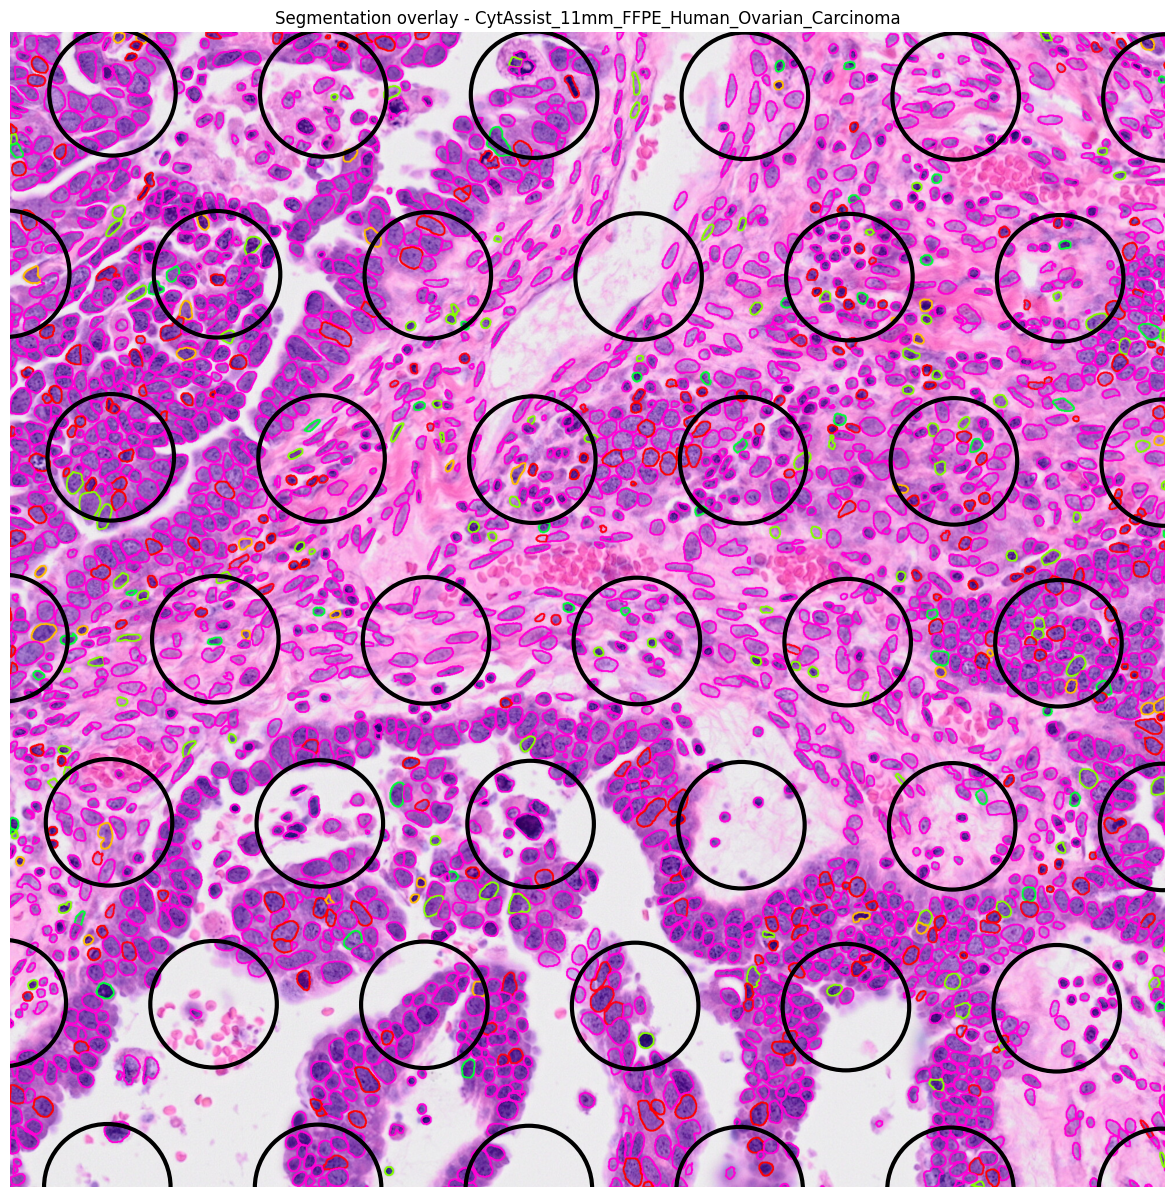

In [39]:
plotter.plot_seg(show_visium=True, draw_dot=False)

In [5]:
from tools.hovernet_tools import map_cells_to_spots
spot_dict = map_cells_to_spots(adata, adata_name, json_path)

Mapping cells to spots: 100%|██████████| 352093/352093 [00:01<00:00, 225102.52it/s]


Randomly selected spot_id: TAAGAAGTTATGCGTG-1


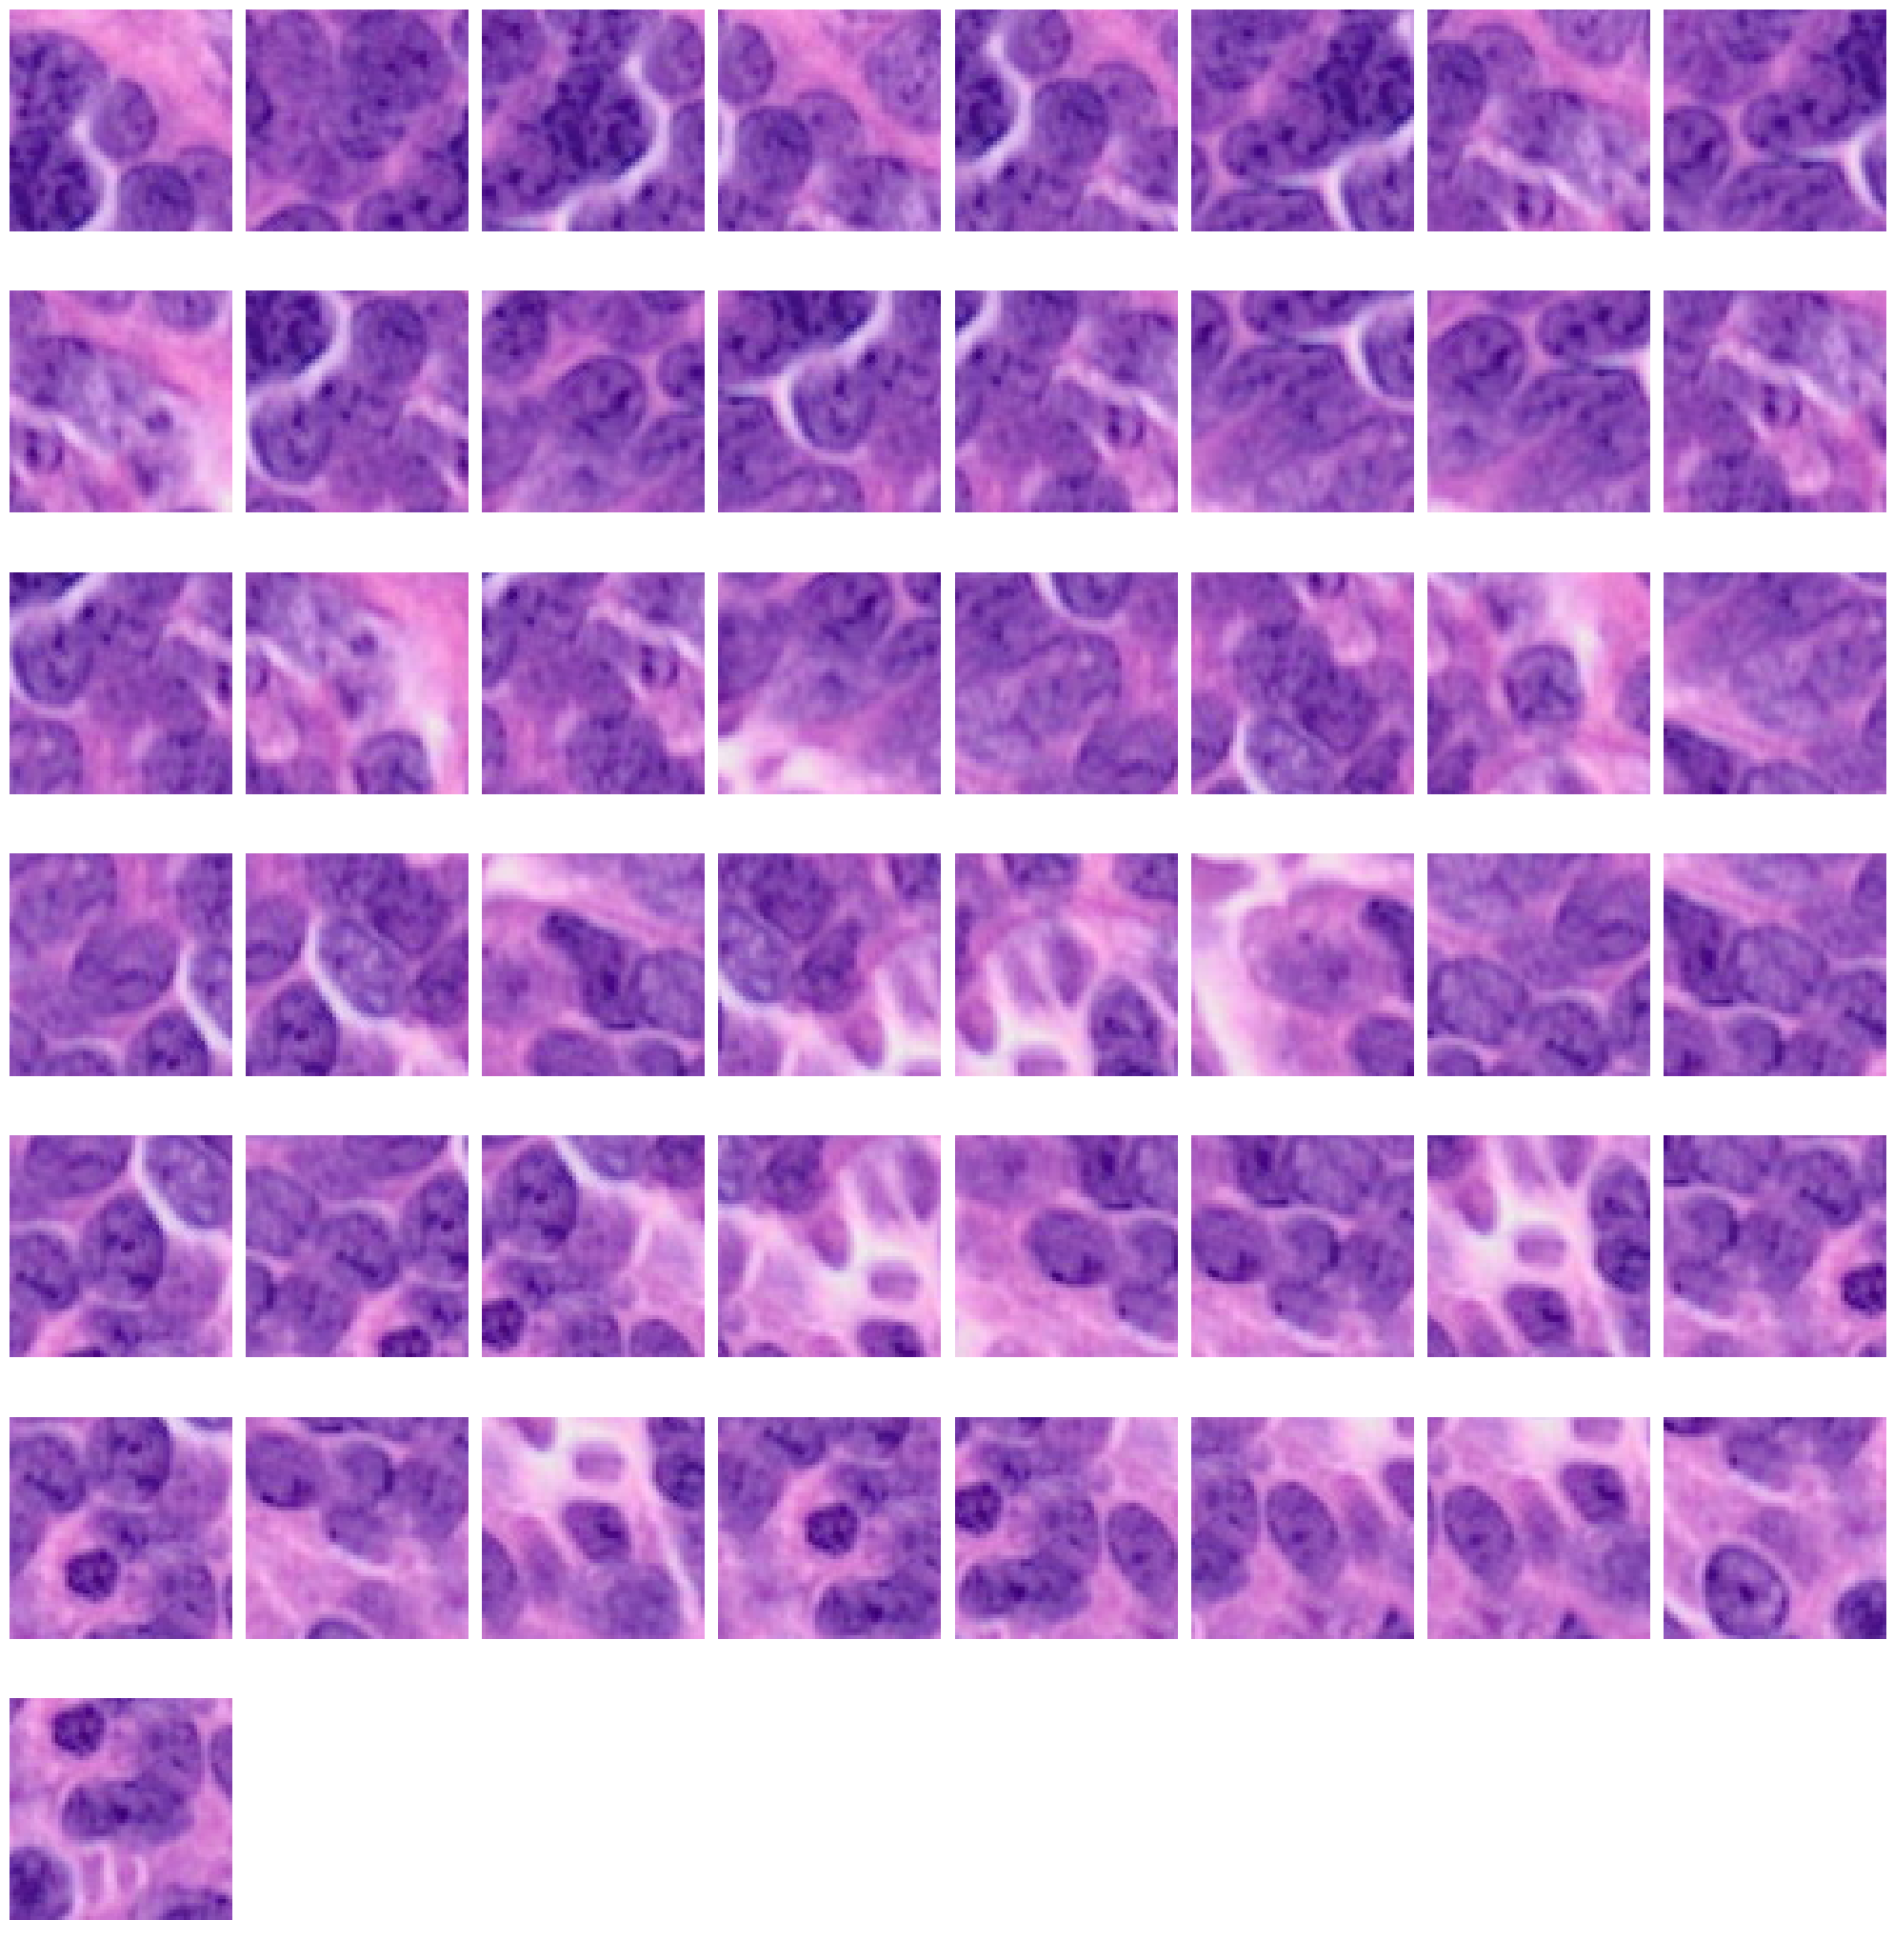

In [15]:
from tools.analysis import plot_mosaic_cells, plot_predicted_cell_labels_in_spot
plot_mosaic_cells(spot_dict, 
                  image_dict, 
                  labels_pred=None, 
                  spot_id=None) #"AGATCTATAAGGCTTC-1"

TIFFReadDirectory: Warning, Unknown field with tag 33560 (0x8318) encountered.


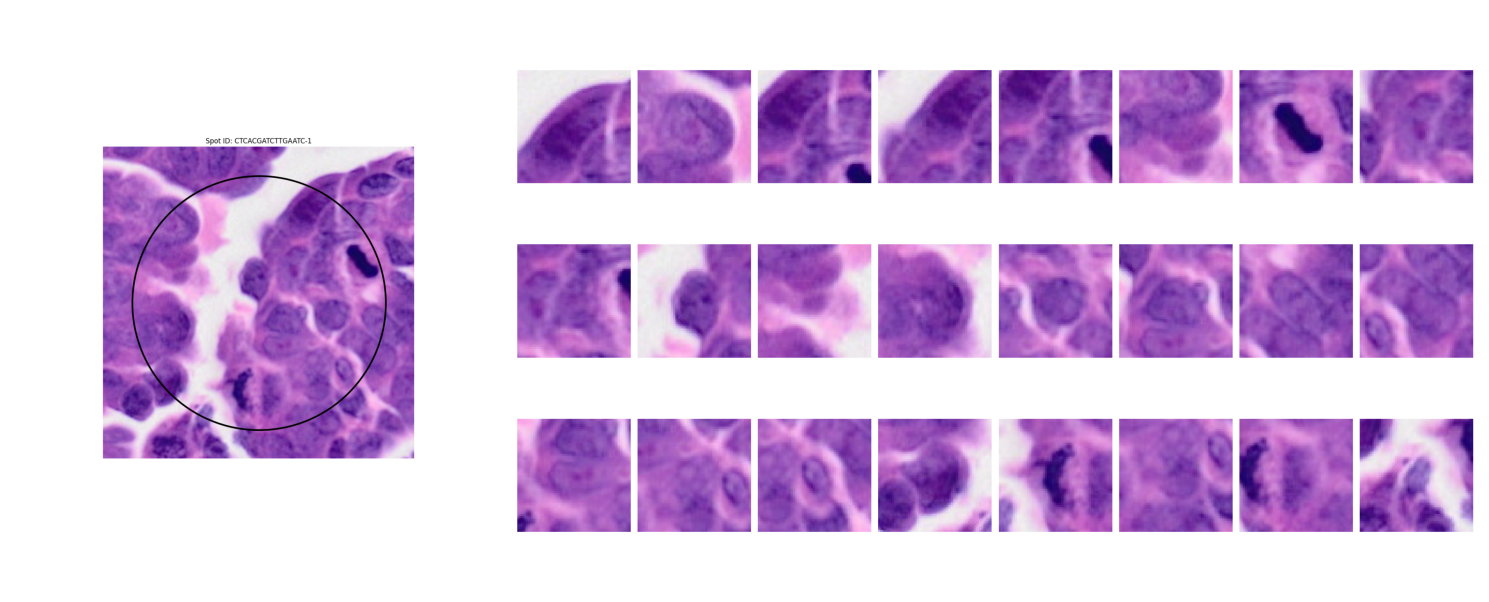

In [30]:
plot_predicted_cell_labels_in_spot(spot_dict,
                                   image_path, 
                                   adata, 
                                   adata_name, #json_path,
                                   image_dict,
                                   spot_id="CTCACGATCTTGAATC-1",
                                   display=True)

# Tests on loss

In [11]:
# def loss_comb_test(outputs, true_proportions, agg = 'mean', alpha=0.5):
        
#     max_prob_loss = - torch.mean(torch.log(outputs.max(dim=1)[0]))
#     if agg == 'mean':
#         pred_proportions = outputs.mean(dim=0)
#     elif agg == 'onehot':
#         predicted_classes = torch.argmax(outputs, dim=1)  # Obtenir les classes prédites
#         one_hot_preds = torch.nn.functional.one_hot(predicted_classes, num_classes=outputs.size(1))
#         pred_proportions = one_hot_preds.float().sum(dim=0) / outputs.size(0)
        
#     divergence_loss = F.mse_loss(pred_proportions, true_proportions)
    
#     # Combined loss
#     loss = alpha * max_prob_loss + (1 - alpha) * divergence_loss
    
#     return loss

In [12]:
# import torch.nn.functional as F
# outputs_t = F.softmax(torch.rand(10, 6), dim=1)
# true_pp_t = F.softmax(torch.rand(6), dim=0)

In [56]:
# outputs_t = torch.tensor([[0.2, 0.1, 0.3, 0.1, 0.2, 0.1],
#         [0.15, 0.2, 0.1, 0.2, 0.3, 0.05],
#         [0.25, 0.1, 0.1, 0.2, 0.05, 0.3],
#         [0.3, 0.2, 0.25, 0.05, 0.1, 0.1],
#         [0.2, 0.2, 0.2, 0.3, 0, 0.1]])

In [14]:
# true_pp_t

In [15]:
# pred_t = torch.nn.functional.one_hot(torch.argmax(outputs_t, dim=1), num_classes=outputs_t.size(1)).float().sum(dim=0) / outputs_t.size(0)
# pred_t

In [16]:
# pred_t = outputs_t.mean(dim=0)
# pred_t

In [17]:
# F.mse_loss(pred_t, true_pp_t)*1e2, - torch.mean(torch.log(outputs_t.max(dim=1)[0]))

# Tests on datasets

In [18]:
# from utils.hovernet_tools import map_cells_to_spots
# from data.load_data import split_data
# spot_dict = map_cells_to_spots(adata, adata_name, json_path)

In [19]:
# from data.load_data import SpotDataset, collate_fn

# train_spot_dict, train_proportions, val_spot_dict, val_proportions, test_spot_dict, test_proportions = split_data(
#         spot_dict, proportions, train_size=0.5, val_size=0.25)
    
# # Create datasets
# train_dataset = SpotDataset(train_spot_dict, train_proportions, image_dict)
# val_dataset = SpotDataset(val_spot_dict, val_proportions, image_dict)
# test_dataset = SpotDataset(test_spot_dict, test_proportions, image_dict)

In [20]:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn) #added collate_fn
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn) #added collate_fn
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn) #added collate_fn

In [21]:
# for batch in train_loader:
#     test_images = batch[0][0]
#     test_vector = batch[1][0]
#     break

In [22]:
# test_images.shape

In [23]:
# test_vector

In [24]:
# import numpy as np

# df = proportions.copy()
# df['distance'] = df.apply(lambda row: np.linalg.norm(row.values - test_vector.cpu().numpy()), axis=1)

# # Trouver l'index de la ligne la plus proche
# index_ligne_proche = df['distance'].idxmin()

In [25]:
# proportions.loc[index_ligne_proche]

In [26]:
# len(spot_dict[index_ligne_proche])